In [1]:
#! pip install pmdarima

In [1]:
import pandas as pd
from numpy import log
import datetime as dt
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from sklearn.metrics import r2_score

### Current Code:

In [2]:
def forecast_sales(start_date: datetime, end_date: datetime, sales_data: pd.DataFrame):
    
    days_to_forecast = (end_date - start_date).days
    mean_daily_sales = sales_data[sales_data['date'] < start_date]['sales'].mean()
    return mean_daily_sales * days_to_forecast

In [3]:
def calculate_new_order (order_date: datetime, lead_time_days: int, days_to_next_order: int, 
                         sales_data: pd.DataFrame, current_stock_level: int, stock_in_transit: int):
    
    arrival_date = order_date + timedelta(days=lead_time_days)
    next_arrival_date = order_date + timedelta(days=days_to_next_order + lead_time_days)
    
    forecast_leadtime = forecast_sales(order_date, arrival_date, sales_data)
    estimated_stock_at_arrival = current_stock_level - forecast_leadtime + stock_in_transit 
    
    forecast_planning_horizon = forecast_sales(arrival_date,next_arrival_date, sales_data)
    order = max(0,forecast_planning_horizon - estimated_stock_at_arrival)
    return order

### Calculate Reordering


In [4]:
order_date = datetime(2020,6,1)
lead_time_days = 90
days_to_next_order = 30
current_stock_level = 400
stock_in_transit = 600

In [5]:
sales_data = pd.read_csv('sales_data.csv',parse_dates=['date'])

In [6]:
calculate_new_order (order_date=order_date, 
                   lead_time_days=lead_time_days, 
                   days_to_next_order=days_to_next_order, 
                   sales_data=sales_data, 
                   current_stock_level=current_stock_level, 
                   stock_in_transit=stock_in_transit)


186.0598684820378

## Exploratory Data Analysis 

In [7]:
sales_data = sales_data.set_index(keys = 'date')
sales_data.head()

,sales
date,
2016-06-01,12
2016-06-02,22
2016-06-03,19
2016-06-04,20
2016-06-05,5


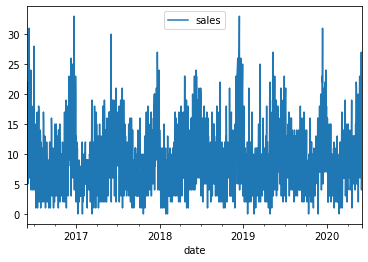

In [8]:
sales_data.plot()
plt.show()

We can observe that there is a seasonality associated with the data

### Dickey-Fuller Test

In [9]:
X = sales_data.sales
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.626367
p-value: 0.000001
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

### Autocorrelation

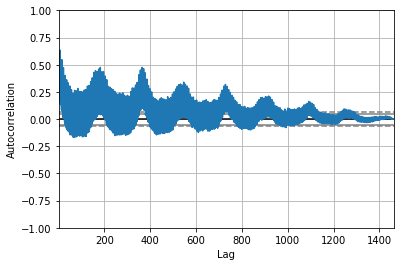

In [10]:
autocorrelation_plot(sales_data)
plt.show()

# MODELO ARIMA

### TRAIN - TEST

In [11]:
date0 = datetime(2020, 2, 1)
date1 = datetime(2020, 5, 1)

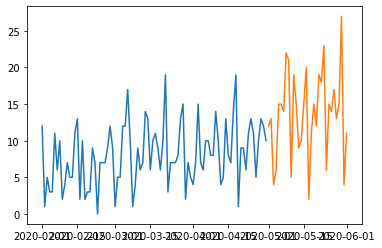

In [12]:
train = sales_data[(date0 <= sales_data.index) & (sales_data.index < date1)]
test = sales_data[date1 <= sales_data.index]
plt.plot(train)
plt.plot(test)

### Definición Modelo ARIMA

In [13]:
stepwise_model = auto_arima(train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)


In [14]:
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   90
Model:             SARIMAX(3, 1, 1)x(2, 1, [], 12)   Log Likelihood                -234.312
Date:                             Sat, 06 Feb 2021   AIC                            482.624
Time:                                     21:24:12   BIC                            499.031
Sample:                                          0   HQIC                           489.187
                                              - 90                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0967      0.149      0.647      0.518      -0.196       0.390
ar.L2         -0.1479      0.114     -1.295      0.195      -0.372       0.076
ar.L3         -0.1645      0.144     -1.139      0.255      -0.447       0.118
ma.L1         -0.9748      0.096    -10.102      0.000      -1.164      -0.786
ar.S.L12      -0.8634      0.147     -5.854      0.000      -1.152      -0.574
ar.S.L24      -0.3674      0.137     -2.673      0.008      -0.637      -0.098
sigma2        21.3924      4.566      4.685      0.000      12.444      30.341
===================================================================================
Ljung-Box (Q):                      132.61   Jarque-Bera (JB):                 0.44
Prob(Q):                              0.00   Prob(JB):                         0.80
Heteroskedasticity (H):               0.71   Skew:                            -0.06
Prob(H) (two-sided):                  0.38   Kurtosis:                         2.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predict

In [15]:
prediction = pd.DataFrame(stepwise_model.predict(n_periods = test.shape[0]), index = test.index, columns = ['predicted'])

C:\Users\dayan\anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Unrecognized location 'Left corner'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  """


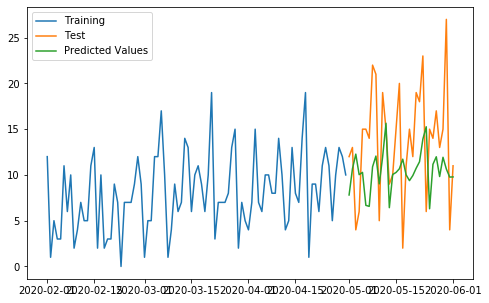

In [16]:
plt.figure(figsize = (8,5))
plt.plot(train, label = 'Training')
plt.plot(test, label = 'Test')
plt.plot(prediction, label = 'Predicted Values')
plt.legend(loc = 'Left corner')
plt.show()

### Metric

In [17]:
test['predicted_sales'] = prediction
r2_score(test['sales'], test['predicted_sales'])

C:\Users\dayan\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


-0.34776534642046375

# Comparing Results

In [18]:
sales_data_orig = pd.read_csv('sales_data.csv',parse_dates=['date'])

In [31]:
def comparing_results(start_date, end_date):
    # Real Sales
    real_sales = sales_data_orig[(start_date <= sales_data_orig.date) & (
        sales_data_orig.date < end_date)]
    # Predicted Sales
    days_to_forecast = (end_date - sales_data_orig.date.max()).days
    date_list = [sales_data_orig.date.max() + timedelta(days=x)
                 for x in range(days_to_forecast)]
    prediction_results = pd.DataFrame(stepwise_model.predict(
        n_periods=days_to_forecast), index=date_list, columns=['predicted'])
    prediction_results = prediction_results[(
        start_date <= prediction_results.index) & (prediction_results.index < end_date)]
    # Mean model Sales
    mean_model = forecast_sales(start_date, end_date, sales_data_orig)
    # Results
    results = pd.DataFrame({'Real': real_sales.sales.sum(),
                            'Predicted': prediction_results.predicted.sum(),
                            'Mean_model': mean_model},
                           columns=['Real', 'Predicted', 'Mean_model'],
                           index=[start_date])
    if start_date >= datetime(2020, 6, 1):
        results = results[['Predicted', 'Mean_model']]
    return results

### 1. Dates in DataFrame

In [36]:
comparing_results(datetime(2020, 6, 1), datetime(2020, 7, 1))

,Predicted,Mean_model
2020-06-01,315.546315,296.50924


### 2. Dates example

In [37]:
comparing_results(datetime(2020, 7, 1), datetime(2020, 8, 1))

,Predicted,Mean_model
2020-07-01,370.803201,306.416553


### 3. Future Dates

In [35]:
comparing_results(datetime(2020,6,1), datetime(2020,10,1))
comparing_results(datetime(2020,8,1), datetime(2020,9,1))

,Predicted,Mean_model
2020-08-01,410.109034,306.416553


In [23]:
def new_forcast_arima(date1, date2):
    date0 = date1 - timedelta(days=(date2-date1).days*3)
    train = sales_data[(date0 <= sales_data.index)
               & (sales_data.index < date1)]
    test = sales_data[(date1 <= sales_data.index)
               & (sales_data.index < date2)]
    model = auto_arima(train, start_p=1, start_q=1,
                                max_p=3, max_q=3, m=12,
                                start_P=0, seasonal=True,
                                d=1, D=1,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True,
                               return_valid_fits = False)
    prediction = pd.DataFrame(model.predict(
        n_periods=test.shape[0]), index=test.index, columns=['predicted'])
    return prediction

In [24]:
def comparing_results_prueba(start_date, end_date):
    # Real Sales
    real_sales = sales_data_orig[(start_date <= sales_data_orig.date) & (
        sales_data_orig.date < end_date)]
    # Predicted Sales
    prediction_results = new_forcast_arima(start_date, end_date)
    # Mean model Sales
    mean_model = forecast_sales(start_date, end_date, sales_data_orig)
    # Results
    results = pd.DataFrame({'Real': real_sales.sales.sum(), 
                            'Predicted': prediction_results.predicted.sum(), 
                            'Mean_model': mean_model},
                           columns=['Real', 'Predicted', 'Mean_model'], 
                           index=[start_date])
    if start_date >= datetime(2020,6,1):
        results = results[['Predicted', 'Mean_model']]
    return results

In [306]:
def new_calculate_new_order(order_date: datetime, lead_time_days: int, days_to_next_order: int, 
                         sales_data: pd.DataFrame, current_stock_level: int, stock_in_transit: int):
    
    arrival_date = order_date + timedelta(days=lead_time_days)
    next_arrival_date = order_date + timedelta(days=days_to_next_order + lead_time_days)
    
    forecast_leadtime = new_forcast_arima(order_date, arrival_date)
    estimated_stock_at_arrival = current_stock_level - forecast_leadtime + stock_in_transit 
    
    forecast_planning_horizon = new_forcast_arima(arrival_date, next_arrival_date)
    order = max(0,forecast_planning_horizon - estimated_stock_at_arrival)
    return order

In [25]:
comparing_results_prueba(datetime(2020, 5, 1), datetime(2020, 6, 1))

,Real,Predicted,Mean_model
2020-05-01,426,370.031709,303.8
